In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import skimage
from scipy.ndimage.measurements import histogram
from skimage.filters.rank import entropy
from sklearn.cluster import KMeans
from scipy import ndimage
import impavi 

# Image Segmentation techniques ( 1/3 )

The first image I will work with is the easiest one for segmentation. This part of the study will provide a general idea of how segmentation can be performed and will serve as introduction to better understand the next, more problematic images. As you can see in the image below, **segmentation can not be performed based on color (or gray-scale value)** so I will have to find other properties that vary between regions. 

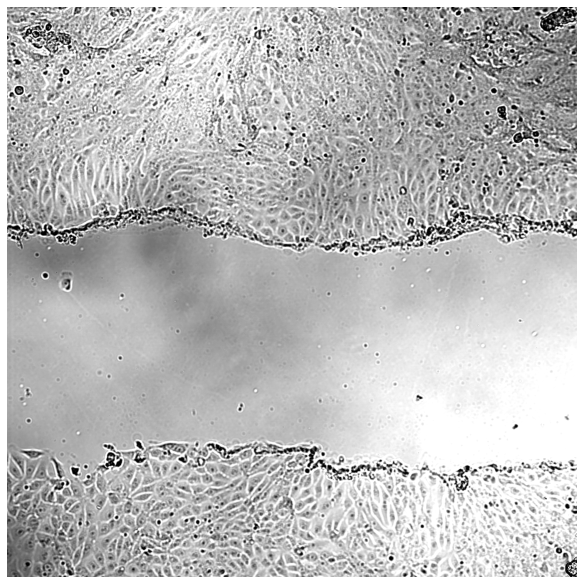

In [2]:
impavi.show('DIC_SN_15_L10_Sum00.tif')

## State of the Art algorithms results

The function below displays the results obtained by the state of the art algorithms whith the corresponding SSIM obtained by each one. Note that it also shows the manually segmented image which will be used as target for the rest of the project.

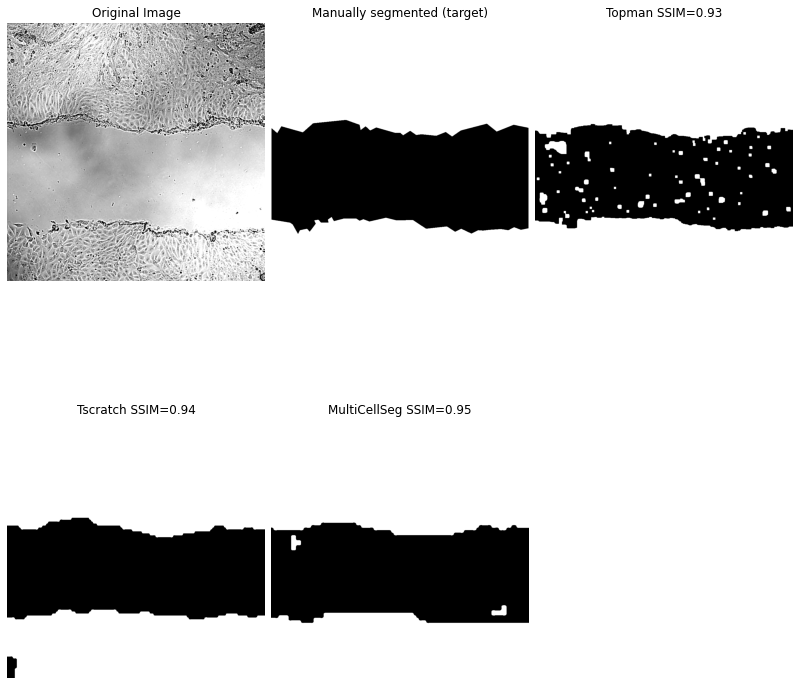

In [3]:
impavi.state_of_the_art('DIC_SN_15_L10_Sum00')

## Equalizing the image improves contrast and texture in saturated regions

First of all, you can clearly see how the bottom right corner of the image has a high saturation and the texture is lost. I will first equalize the image in order to gain texture in those regions. 

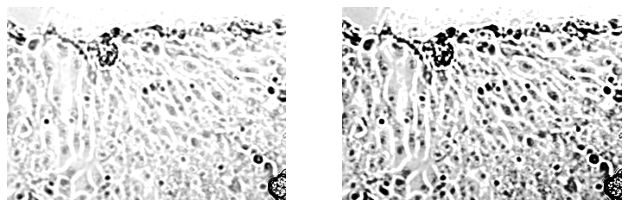

In [4]:
im = plt.imread('DIC_SN_15_L10_Sum00.tif')
im_eq = impavi.equalize(im,plot=False)

plt.figure(figsize=(11,11))
plt.subplot(121)
plt.axis('off')
plt.imshow(im[800:,700:],cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.imshow(im_eq[800:,700:],cmap='gray')

# High pass filter aproach

The idea behind this kind of segmentation relies on the structure difference between the central cut and the tissue. I will exploit the texture properties of the membrane to differentiate it from the wound. 

One possible approach is to try to retain the parts of the image with high detail. In other words, gather information aboout change of contrast, edges, shapes, etc. This can be achieved by applying a "high pass filter" to the Fourier Transform of the image. This means dropping the low frequencies in the Fourier space and keeping just the frequencies in charge of these properties (change of contrast, edges, shapes, etc).

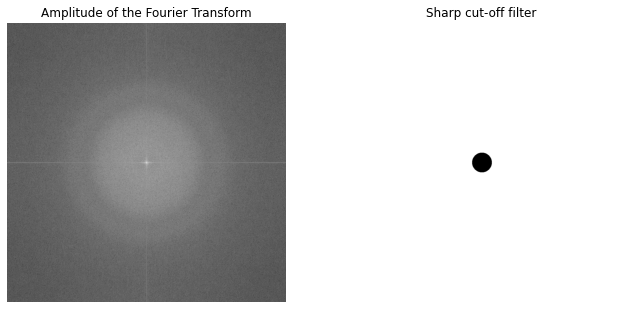

In [6]:
#Fast Fourier Transform
im_tf = np.fft.fftshift(np.fft.fft2(im_eq))
#build Laplacian Filter 
u, v = np.meshgrid(np.linspace(-1, 1, im.shape[0]), np.linspace(-1, 1, im.shape[1]))
lf = u**2 + v**2
circ = lf>0.005

plt.figure(figsize=(11,11))
plt.subplot(121)
plt.axis('off')
plt.title('Amplitude of the Fourier Transform')
plt.imshow(np.log10(np.abs(im_tf)),cmap='gray')
plt.subplot(122)
plt.title('Sharp cut-off filter')
plt.axis('off')
plt.imshow(circ,cmap='gray')

The resulting image after applying the filter is shown below

(-0.5, 1023.5, 1023.5, -0.5)

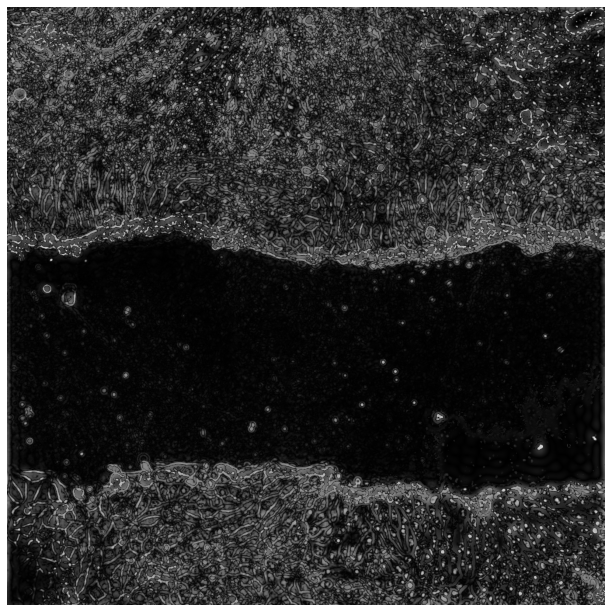

In [7]:
im1 = np.abs(np.fft.ifft2(im_tf*circ))

plt.figure(figsize=(11,11))
plt.imshow(im1,cmap='gray')
plt.axis('off')

This new representation provides a change in mean pixel value between the wound and the tissue. Now we can begin the segmentation process.

I proceed to average the image with a very specific filter. That is, a rectangular filter with a higher dimension along the horizontal axis. This will minimize the loss of information at the edges of the cut and will get rid of the noise (white spots) on the cut region. 

(-0.5, 1023.5, 1023.5, -0.5)

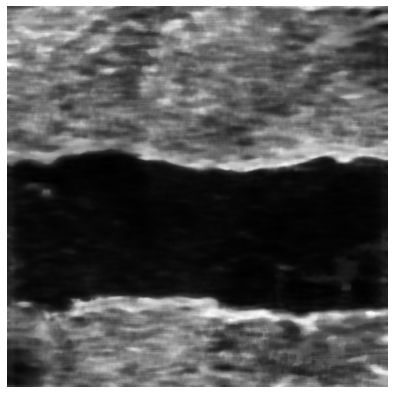

In [8]:
median = ndimage.median_filter(im1, size=[11,41])
plt.figure(figsize=(7,7))
plt.imshow(median,cmap='gray')
plt.axis('off')

Now, one last "medfilt" will be enough to perform the final segmentation. 

(-0.5, 1023.5, 1023.5, -0.5)

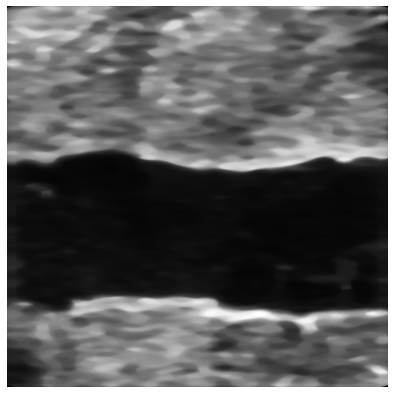

In [9]:
# second MEDIAN THRESHOLD
# media = scipy.signal.medfilt(im, [mask size])
# ordena los valores de la imagen dentro de mask y coge el del medio
median2 = scipy.signal.medfilt2d(median, kernel_size=[11,41])
plt.figure(figsize=(7,7))
plt.imshow(median2,cmap='gray')
plt.axis('off')

The Otsu thresholding method appears insufficient when trying to binarize this image. K-means clustering will provide a much more fine segmentation (see next steps).

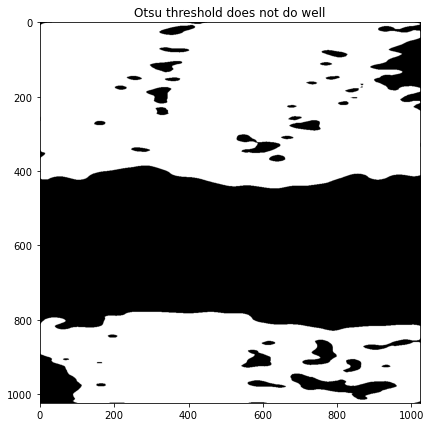

In [11]:
otsu = median2>skimage.filters.threshold_otsu(median2)
plt.figure(figsize=(7,7))
plt.title('Otsu threshold does not do well')
plt.imshow(otsu,cmap='gray')

## K-means clustering

The next function I built (can be found in the "impavi" module) performs K-means to the image using k=7 in this case. This allows to have a better, more refined segmentation than just a binarization. I built he function "apply_kmeans" so that it automatically returns the largest cluster out of the k clusters. 

(-0.5, 1023.5, 1023.5, -0.5)

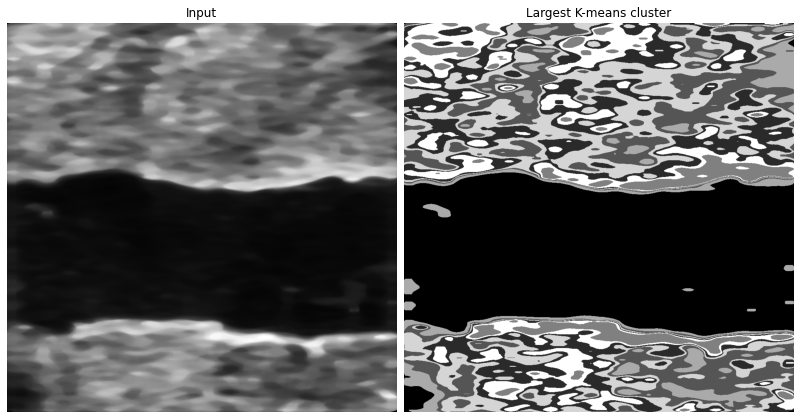

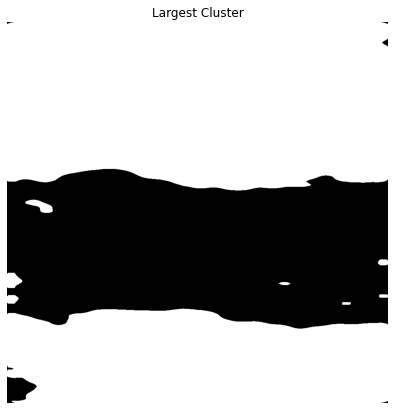

In [13]:
im_seg = impavi.apply_kmeans(median2,7,plot=True)
plt.figure(figsize=(7,7))
plt.title('Largest Cluster')
plt.imshow(im_seg,cmap='gray')
plt.axis('off')

## SSIM of my result and of all the other algorithms

I finally proceed to compare the result obtained with the solution built manually provided in the dataset. 

In [18]:
target = plt.imread('DIC_SN_15_L10_Sum00_manual.png')
ssim = skimage.metrics.structural_similarity(target,im_seg)
print('The SSIM between the target and my result is:',ssim)

The SSIM between the target and my result is: 0.9592280043626258


/Users/codefrom0/opt/anaconda3/lib/python3.9/site-packages/skimage/_shared/utils.py:293: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


The next function computes SSIM between the target and also of all possible combinations between my result and the state of the art algorithms' results. This provides a correlation matrix that can be represented with highly visual information about the performance of each one of the results.

In [15]:
ssim = impavi.ssim_matrix('DIC_SN_15_L10_Sum00',im_seg)

In [16]:
print(ssim)

[[1.    0.933 0.942 0.951 0.959]
 [0.933 1.    0.923 0.941 0.944]
 [0.942 0.923 1.    0.955 0.949]
 [0.951 0.941 0.955 1.    0.959]
 [0.959 0.944 0.949 0.959 1.   ]]


<AxesSubplot:>

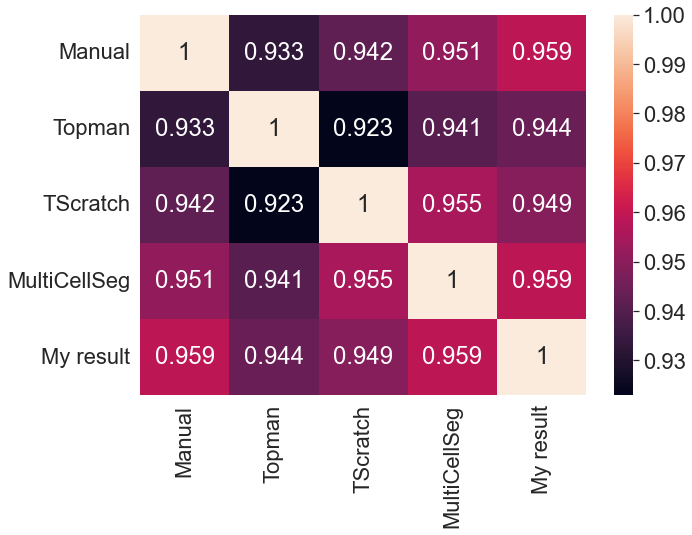

In [17]:
import seaborn as sn
import pandas as pd
sn.set(font_scale=2)

df_cm = pd.DataFrame(ssim, index = [i for i in ['Manual','Topman','TScratch','MultiCellSeg','My result']],
                  columns = [i for i in ['Manual','Topman','TScratch','MultiCellSeg','My result']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='.3g',)
